Populating the interactive namespace from numpy and matplotlib


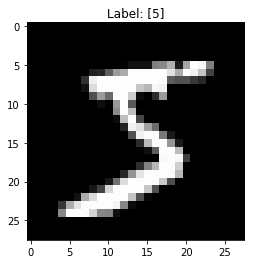

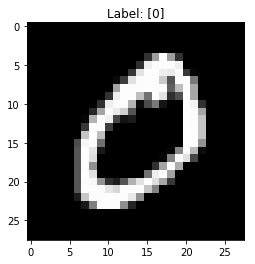

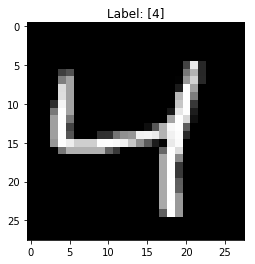

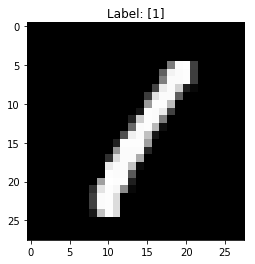

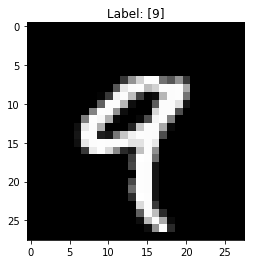

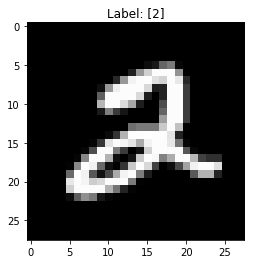

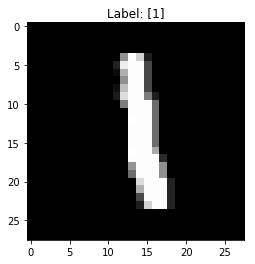

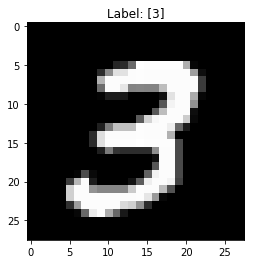

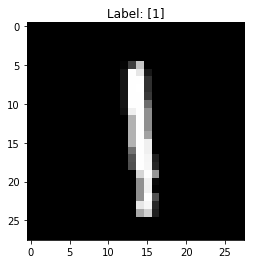

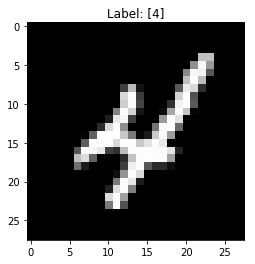

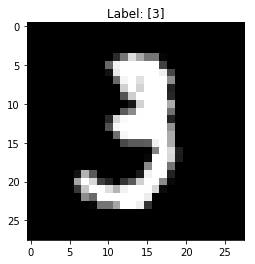

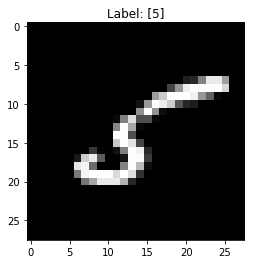

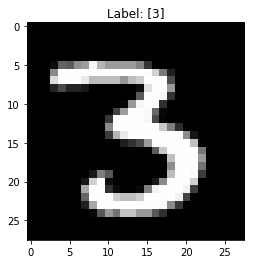

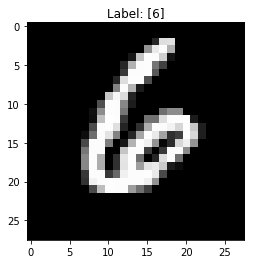

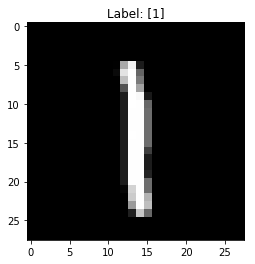

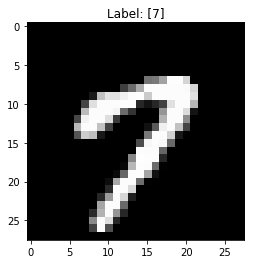

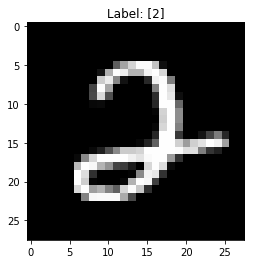

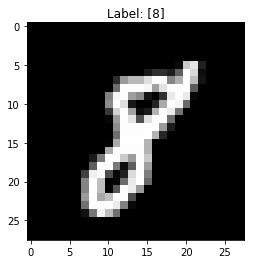

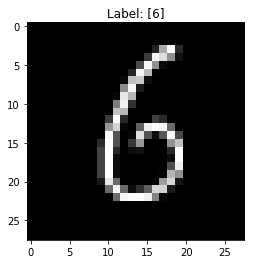

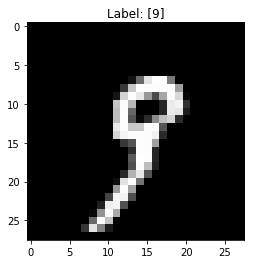

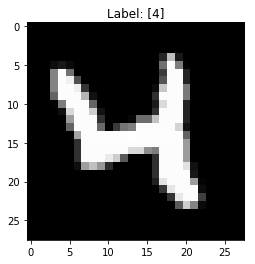

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms


# Load and plot
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, label) in enumerate(train_loader_plot):
    plt.imshow(data.view(1,28,28).squeeze().numpy(), cmap='gray')
    plt.title('Label: ' + str(label.numpy()))
    plt.show()
    if batch_idx == 20:
        break


In [2]:
def log_bernoulli_loss(x_hat, x):
    return -torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))

In [3]:
def KL_loss(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

In [4]:
def loss_function(x_hat, x, mu, logvar):
    return log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)

In [5]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        x_embedded = F.relu(self.fc1(x))
        mu = self.fc21(x_embedded)
        logvar = self.fc22(x_embedded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        return mu + torch.exp(0.5 * logvar) * torch.randn_like(logvar)

    def decode(self, z):
        decoded_z = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(decoded_z))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar
        
        
VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


In [10]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [11]:
# Hyperparameters
fc1_dims = (784, 8)
fc21_dims = (8, 2)
fc22_dims = (8, 2)
fc3_dims = (2, 8)
fc4_dims = (8, 784)
lr = 1e-4
batch_size = 10
epochs = 10

In [12]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 571.870422
Train Epoch: 1 [1000/60000 (2%)]	Loss: 560.244202
Train Epoch: 1 [2000/60000 (3%)]	Loss: 542.773193
Train Epoch: 1 [3000/60000 (5%)]	Loss: 532.346741
Train Epoch: 1 [4000/60000 (7%)]	Loss: 523.042358
Train Epoch: 1 [5000/60000 (8%)]	Loss: 512.286865
Train Epoch: 1 [6000/60000 (10%)]	Loss: 503.733734
Train Epoch: 1 [7000/60000 (12%)]	Loss: 480.793304
Train Epoch: 1 [8000/60000 (13%)]	Loss: 453.824799
Train Epoch: 1 [9000/60000 (15%)]	Loss: 428.325195
Train Epoch: 1 [10000/60000 (17%)]	Loss: 404.642059
Train Epoch: 1 [11000/60000 (18%)]	Loss: 342.927856
Train Epoch: 1 [12000/60000 (20%)]	Loss: 326.759766
Train Epoch: 1 [13000/60000 (22%)]	Loss: 317.784943
Train Epoch: 1 [14000/60000 (23%)]	Loss: 313.721527
Train Epoch: 1 [15000/60000 (25%)]	Loss: 298.452881
Train Epoch: 1 [16000/60000 (27%)]	Loss: 284.476196
Train Epoch: 1 [17000/60000 (28%)]	Loss: 299.887909
Train Epoch: 1 [18000/60000 (30%)]	Loss: 247.976654
Train Epoch: 1 [19000/60000 (32

Train Epoch: 3 [38000/60000 (63%)]	Loss: 176.997589
Train Epoch: 3 [39000/60000 (65%)]	Loss: 170.957336
Train Epoch: 3 [40000/60000 (67%)]	Loss: 195.882111
Train Epoch: 3 [41000/60000 (68%)]	Loss: 167.775543
Train Epoch: 3 [42000/60000 (70%)]	Loss: 184.893829
Train Epoch: 3 [43000/60000 (72%)]	Loss: 197.431961
Train Epoch: 3 [44000/60000 (73%)]	Loss: 199.807938
Train Epoch: 3 [45000/60000 (75%)]	Loss: 208.065155
Train Epoch: 3 [46000/60000 (77%)]	Loss: 165.705963
Train Epoch: 3 [47000/60000 (78%)]	Loss: 172.094955
Train Epoch: 3 [48000/60000 (80%)]	Loss: 190.239029
Train Epoch: 3 [49000/60000 (82%)]	Loss: 178.008331
Train Epoch: 3 [50000/60000 (83%)]	Loss: 173.231232
Train Epoch: 3 [51000/60000 (85%)]	Loss: 190.208191
Train Epoch: 3 [52000/60000 (87%)]	Loss: 180.790085
Train Epoch: 3 [53000/60000 (88%)]	Loss: 195.573822
Train Epoch: 3 [54000/60000 (90%)]	Loss: 177.685425
Train Epoch: 3 [55000/60000 (92%)]	Loss: 166.124481
Train Epoch: 3 [56000/60000 (93%)]	Loss: 186.808319
Train Epoch:

Train Epoch: 6 [16000/60000 (27%)]	Loss: 169.226410
Train Epoch: 6 [17000/60000 (28%)]	Loss: 187.617065
Train Epoch: 6 [18000/60000 (30%)]	Loss: 183.780579
Train Epoch: 6 [19000/60000 (32%)]	Loss: 166.952988
Train Epoch: 6 [20000/60000 (33%)]	Loss: 179.460526
Train Epoch: 6 [21000/60000 (35%)]	Loss: 194.095779
Train Epoch: 6 [22000/60000 (37%)]	Loss: 198.005280
Train Epoch: 6 [23000/60000 (38%)]	Loss: 181.045044
Train Epoch: 6 [24000/60000 (40%)]	Loss: 167.473434
Train Epoch: 6 [25000/60000 (42%)]	Loss: 152.761810
Train Epoch: 6 [26000/60000 (43%)]	Loss: 178.797150
Train Epoch: 6 [27000/60000 (45%)]	Loss: 173.770004
Train Epoch: 6 [28000/60000 (47%)]	Loss: 165.428192
Train Epoch: 6 [29000/60000 (48%)]	Loss: 180.549591
Train Epoch: 6 [30000/60000 (50%)]	Loss: 169.817871
Train Epoch: 6 [31000/60000 (52%)]	Loss: 166.665985
Train Epoch: 6 [32000/60000 (53%)]	Loss: 195.692047
Train Epoch: 6 [33000/60000 (55%)]	Loss: 189.372116
Train Epoch: 6 [34000/60000 (57%)]	Loss: 182.521149
Train Epoch:

Train Epoch: 8 [54000/60000 (90%)]	Loss: 147.869843
Train Epoch: 8 [55000/60000 (92%)]	Loss: 197.189133
Train Epoch: 8 [56000/60000 (93%)]	Loss: 172.483917
Train Epoch: 8 [57000/60000 (95%)]	Loss: 169.539703
Train Epoch: 8 [58000/60000 (97%)]	Loss: 165.152191
Train Epoch: 8 [59000/60000 (98%)]	Loss: 196.808716
====> Epoch: 8 Average loss: 177.9754
Train Epoch: 9 [0/60000 (0%)]	Loss: 195.644928
Train Epoch: 9 [1000/60000 (2%)]	Loss: 179.354736
Train Epoch: 9 [2000/60000 (3%)]	Loss: 177.413193
Train Epoch: 9 [3000/60000 (5%)]	Loss: 177.050430
Train Epoch: 9 [4000/60000 (7%)]	Loss: 180.099686
Train Epoch: 9 [5000/60000 (8%)]	Loss: 180.099884
Train Epoch: 9 [6000/60000 (10%)]	Loss: 158.315842
Train Epoch: 9 [7000/60000 (12%)]	Loss: 182.441467
Train Epoch: 9 [8000/60000 (13%)]	Loss: 184.959473
Train Epoch: 9 [9000/60000 (15%)]	Loss: 155.890884
Train Epoch: 9 [10000/60000 (17%)]	Loss: 181.094604
Train Epoch: 9 [11000/60000 (18%)]	Loss: 186.175903
Train Epoch: 9 [12000/60000 (20%)]	Loss: 161.

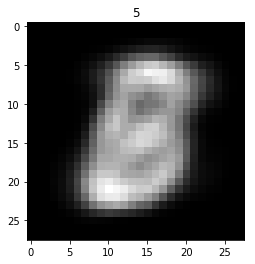

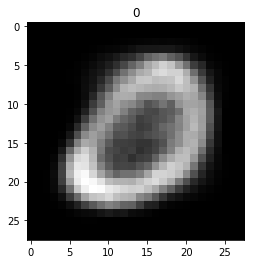

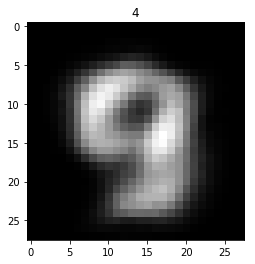

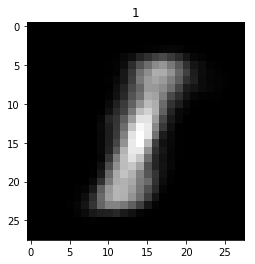

In [13]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break
